## Model Training and Evaluation

In this section, we build machine learning models to predict house prices using the processed dataset from Notebook 01.  
We will:
- Split data into features and target  
- Compare different models  
- Use cross-validation for performance evaluation  
- Select the best-performing model  

In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("All libraries imported")

All libraries imported


In [2]:
# Load processed data from notebook 01
X = pd.read_pickle('data/X_processed.pkl')
X_test = pd.read_pickle('data/X_test_processed.pkl')
y = pd.read_pickle('data/y_log.pkl')   # log1p transformed SalePrice

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Target shape: {y.shape}")

Training features shape: (1460, 244)
Test features shape: (1459, 244)
Target shape: (1460,)


In [3]:
# Quick hold-out split (80/20) — fast model comparison
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nQuick split → Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}")


Quick split → Train: 1168, Validation: 292


### Model Selection Strategy

To identify the most effective model, we compare two strong regression algorithms — Random Forest and XGBoost. Both models handle nonlinear relationships well and perform robustly with tabular data. We evaluate their performance using cross-validation with Root Mean Squared Error (RMSE).

In [4]:
# Compare two models and pick the better one
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

print("\nQuick comparison on validation set (with real money RMSE):")
print("-" * 65)

best_rmse = float('inf')
best_name = None

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_log = model.predict(X_val)
    
    # RMSE in log scale
    rmse_log = mean_squared_error(y_val, pred_log, squared=False)
    
    # Convert back to real dollars for better understanding
    rmse_money = mean_squared_error(
        np.expm1(y_val), np.expm1(pred_log), squared=False
    )
    
    print(f"{name:12} → RMSE (log): {rmse_log:.5f}   |   RMSE ($): ${rmse_money:,.0f}")
    
    if rmse_log < best_rmse:
        best_rmse = rmse_log
        best_name = name

print(f"\nWinner of quick test → {best_name}")


Quick comparison on validation set (with real money RMSE):
-----------------------------------------------------------------
RandomForest → RMSE (log): 0.14775   |   RMSE ($): $30,367
XGBoost      → RMSE (log): 0.13661   |   RMSE ($): $26,225

Winner of quick test → XGBoost


### Cross-Validation

Instead of relying on a single train-test split, we use cross-validation to get a more reliable performance estimate. This reduces the risk of overfitting and helps ensure that the model generalizes well to unseen data. We use RMSE as our main evaluation metric because it aligns with Kaggle's scoring.

In [5]:
# Proper 5-fold Cross-validation for the winner (more reliable score)
print(f"\nSerious check: 5-fold CV for {best_name}")
print("-" * 60)

final_cv_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(
    final_cv_model, X, y,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error'
)

cv_rmse_log = -cv_scores.mean()
cv_rmse_money_approx = np.expm1(cv_rmse_log) * np.expm1(y).mean()

print(f"5-fold CV RMSE (log) : {cv_rmse_log:.5f} ± {cv_scores.std():.5f}")
print(f"≈ Real money error   : ~${cv_rmse_money_approx:,.0f} per house")


Serious check: 5-fold CV for XGBoost
------------------------------------------------------------
5-fold CV RMSE (log) : 0.13183 ± 0.01817
≈ Real money error   : ~$25,495 per house


### Final Model Training

After comparing the models, we train the best-performing model using the entire training dataset. This maximizes its learning capacity and improves prediction accuracy for the final Kaggle submission.

In [6]:
# Train final model on ALL training data
final_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, y)
print("Final model trained on full training set")

Final model trained on full training set


### Feature Importance (Model Interpretability)

Although our goal is prediction accuracy, it is also important to understand **which features most influence house prices**. We extract feature importance from the final model to gain interpretability and insights into the data.

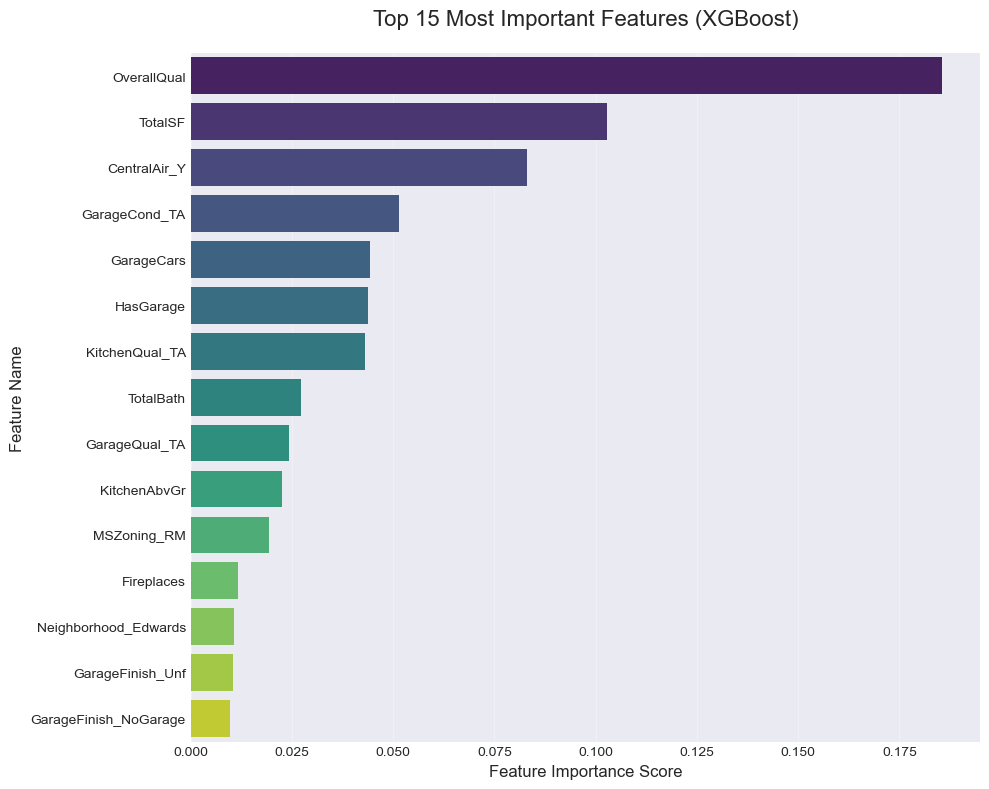

In [7]:
# Feature importance 
importances = pd.Series(final_model.feature_importances_, index=X.columns)
top15 = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=top15.values, y=top15.index, palette="viridis")

plt.title('Top 15 Most Important Features (XGBoost)', fontsize=16, pad=20)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)

plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Generate Kaggle Submission File

We now use the final trained model to generate predictions on the test dataset. These predictions are saved in the required `submission.csv` format for Kaggle submission.

In [8]:
# Predict on test set and reverse log transformation
test_pred_log = final_model.predict(X_test)
test_pred_price = np.expm1(test_pred_log)

print(f"\nPredicted prices: ${test_pred_price.min():,.0f} – ${test_pred_price.max():,.0f}")


Predicted prices: $47,416 – $519,496


In [9]:
# Create Kaggle submission file
submission = pd.DataFrame({
    'Id': pd.read_csv('data/test.csv')['Id'],
    'SalePrice': test_pred_price
})

os.makedirs('submissions', exist_ok=True)
submission.to_csv('submissions/submission.csv', index=False)
print("submission.csv created → ready for Kaggle!")
submission.head()

submission.csv created → ready for Kaggle!


,Id,SalePrice
0,1461,127343.468750
1,1462,165472.968750
2,1463,185577.500000
3,1464,192448.156250
4,1465,184484.671875


### Model Saving for Reuse

To make our work reusable and ready for deployment, we save the trained model using `joblib`. This allows us to load and use the model later without retraining.

In [10]:
# Save model for future use (Streamlit app, etc.)
os.makedirs('models', exist_ok=True)
joblib.dump(final_model, 'models/final_model.pkl')
print("Model saved → models/final_model.pkl")

Model saved → models/final_model.pkl


## Project Summary – Final Results

- Trained and compared **Random Forest** and **XGBoost** models  
- Used **5-fold cross-validation** (RMSE) + log-transformation of SalePrice  
- Best model: **XGBoost**  
  → **5-fold CV RMSE (log scale):** **0.13183** ± 0.01817  
  → **≈ $25,495** average error in real dollars  
  → Kaggle Public Leaderboard: **0.1265**  
- Visualized **feature importance** from the final model  
- Generated final predictions → `submission.csv`  
- Saved production-ready model → `final_model.pkl`